In [2]:
# Visualize tensorboard in the notebook
%load_ext tensorboard
# In order to force reload any changes done to the models package files
%load_ext autoreload
%autoreload 2

In [1]:
## Allow import from our custom lib python files
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(os.path.join(module_path, "lib"))

In [3]:
from datasets.gen_plasma_1d import GenPlasma1DDataset

import os
from timeit import default_timer
import re
from datetime import datetime
import json

# Supress Pandas future deprecation warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import torch
import onnx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg, sparse 
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset
# PyTorch TensorBoard support


# Viz
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
# pio.renderers.default = "notebook+plotly_mimetype+png"
# For some reason, the correct setting to get the plots to show up in Quarto HTML?
pio.renderers.default = "plotly_mimetype+notebook_connected"

from IPython.display import Video

In [4]:
## Params
data_dir = os.path.join("..", "..", "data")
output_dir = os.path.join(data_dir, "output")
tensorboard_dir = os.path.join(output_dir, "tensorboard")

runname = "plasma_newloss_n128"
output_run_dir = os.path.join(output_dir, f"run_{runname}")

runname_seq = "plasma_data_seq"
output_run_dir_seq = os.path.join(output_dir, f"run_{runname_seq}")


# Low Rank Matrix/Tensor Factorization Using NNs

## Motivation

* Computations in Vlasov dynamics and other ares within computational physics often use very large, high-dimensional timeseries data
    * ex. simulated quantum plasma data
* Would benefit from using a smaller approximation of the data
* Neural networks could perform higher-order singular value decomposition (HOSVD), or an approximation of such, with enough accuracy that their solution would be useful and much faster than performing traditional HOSVD

## Data

### 2D

* 64 x 128 (X, V)
* 128 x 256
* in X, V space

### 4D

* 32 x 32 x 64 x 64
* In 2x, 2v space

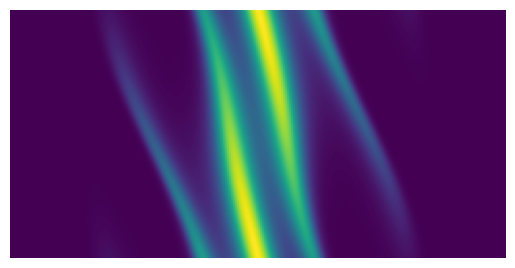

In [32]:
mat_size_seq = [128, 256]
mat_dirs_seq = [os.path.normpath(data_dir + "/gen_plasma_n128/mat_hdf5/")]

# Load and split the data, and prep for being fed into the NN
data_n128_seq = GenPlasma1DDataset(mat_dirs_seq, return_imname=True)
# Divide data into train, validation, test
train_ind_seq = int(len(data_n128_seq) * 0.7)
train_n128, validation_n128 = Subset(data_n128_seq, range(train_ind_seq)),\
    Subset(data_n128_seq, range(train_ind_seq, int(len(data_n128_seq))))
train_dataloader_n128 = DataLoader(train_n128, batch_size=1, shuffle=True, pin_memory=(torch.cuda.is_available()), drop_last=True, num_workers=4)
validation_dataloader_n128 = DataLoader(validation_n128, batch_size=1, shuffle=True, pin_memory=(torch.cuda.is_available()), drop_last=True, num_workers=4)

mat_dirs_64 = [os.path.join(data_dir, "gen_plasma_n64", f"mat_{i}") for i in range(3)]

# Load and split the data, and prep for being fed into the NN
data_n64 = GenPlasma1DDataset(mat_dirs_64, return_imname=True)

plt.axis('off')
plt.imshow(data_n128_seq[2669][0])

Strong 1D problem

In [6]:
Video("../../data/gen_plasma_n64/mat_1_f.mp4", embed=True)

Two stream 1D problem

In [7]:
Video("../../data/gen_plasma_n64/mat_2_f.mp4", embed=True)

Best matrix (lowest loss)

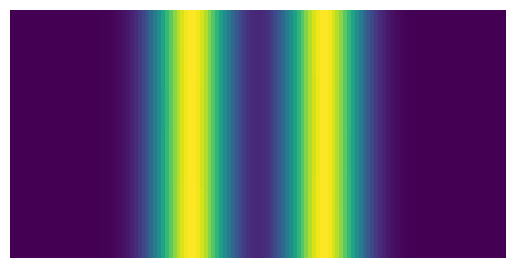

In [8]:
mat_dirs_64 = [os.path.join(data_dir, "gen_plasma_n64", f"mat_{i}") for i in range(3)]

# Load and split the data, and prep for being fed into the NN
data_n64 = GenPlasma1DDataset(mat_dirs_64, return_imname=True)

best_idx = 16302
worst_idx = 21852

plt.axis('off')
plt.imshow(data_n64[best_idx][0])

Worst matrix (highest loss)

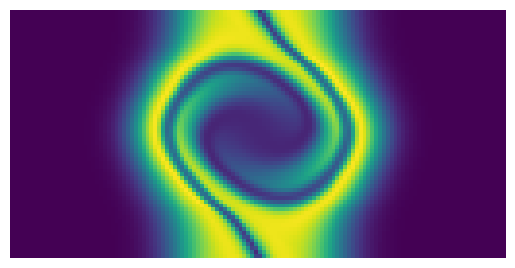

In [9]:
plt.axis('off')
plt.imshow(data_n64[worst_idx][0])

### 4D Example

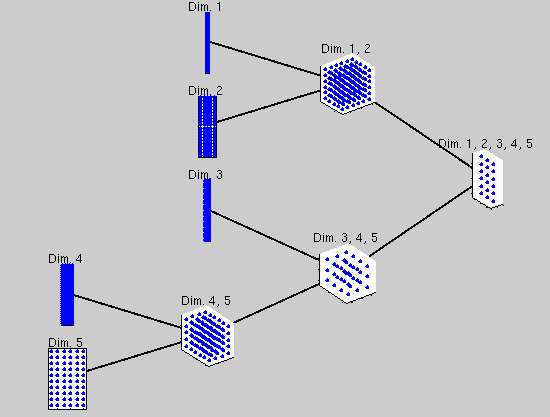

## Models Tested

* 0-2 convolutional layers at start
    * Standard kernel size, stride, padding
* 1-3 linear layers (tanh activation)
* 1-3 linear layers that "fork" from original layer to make pathways of linear layers for U, V (tanh activation)
 
### Data Tested

* 64 x 128
* 128 x 256
* Sequential feeding of data; aka training on first 70% on timeseries matrices, and validating/testing on last 30% (shuffle train data during training to prevent gradient descent bias)

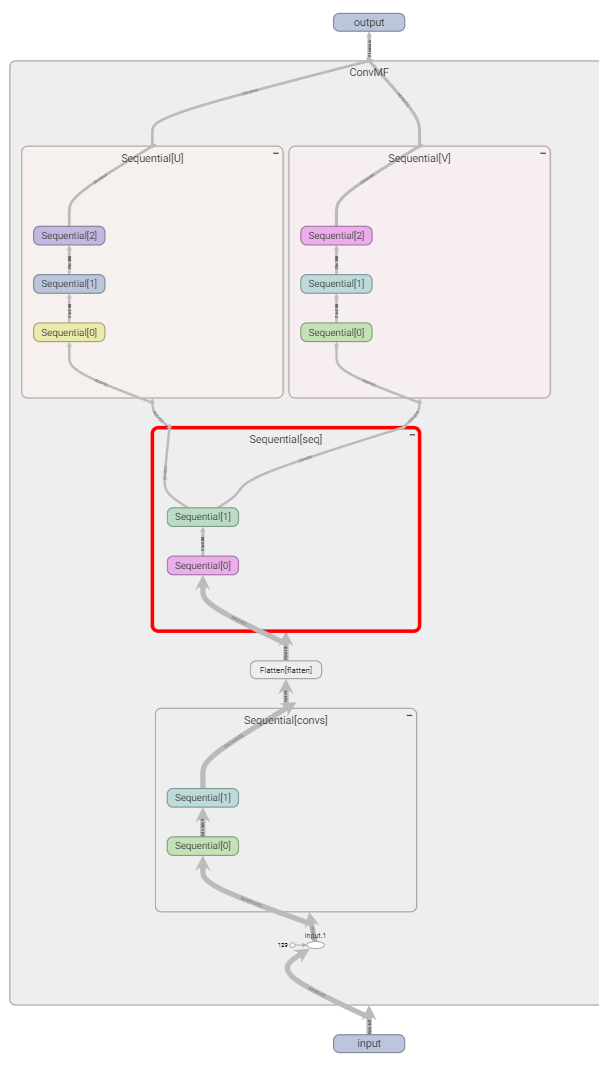

## Training Performance

Best model, 128 x 256 data, rank 6

* blue = Validation, orange = Train

![Training vs Validation Loss](images/n128_cdim2-c00f_tv_loss.svg)

Best model, sequential-used data, rank 6

* grey = Validation, teal = Train

![Training vs Validation Loss](images/n128_seq_cdim2-c00f_tv_loss.svg)

## Comparison Against SVD

### Loss Used

$$
\min_{\substack{U \in \mathbb{R}^{m\times r} \\ V \in \mathbb{R}^{r\times n}}} \dfrac{||X - UV||^2_F}{||X||^2_F} ,
$$

* Where we are finding the square Frobenius norm of the difference between the original matrix $X$ and the  low rank representation matrices $UV$
* Scaled by Frobenius norm of source matrix when evaluating performance against baseline comparison, not during training

### Loss Comparison

Using test data

In [33]:
df_losses = pd.read_csv(os.path.join(output_run_dir, "df_losses.csv"), dtype={"Model": "category", "Name": "category" })

# Get rid of differentiating part of name str so that models of same type but diff rank can be grouped
df_losses["Name"] = df_losses["Name"].str.replace(r"(?:_r\d+)?(_img128)|(?:_r\d+)?(_img64)", "", regex=True)
# Scaled loss
data_sizes = {64: data_n64, 128: data_n128_seq}
df_losses["Loss Scaled"] = df_losses.apply(lambda x: x.Loss / np.linalg.norm(data_sizes[x.Imsize][x.Img][0], ord="fro"), axis=1)
# Rename best model
df_losses["Name"] = df_losses["Name"].str.replace("ConvMF_cdim2-c00f_fdim3-c141", "ConvMF")
df_losses["Name"] = df_losses["Name"].str.replace(r"ConvMF_cdim2-c00f$", "ConvMF", regex=True)
# Drop all other than best model
df_losses = df_losses[df_losses["Name"].isin(["Basic SVD", "Faster SVD", "ConvMF"])]

## Sequential-data NN
df_losses_seq = pd.read_csv(os.path.join(output_run_dir_seq, "df_losses.csv"), dtype={"Model": "category", "Name": "category" })
# Get rid of differentiating part of name str so that models of same type but diff rank can be grouped
df_losses_seq["Name"] = df_losses_seq["Name"].str.replace(r"(?:_r\d+)?(_img128)|(?:_r\d+)?(_img64)", "", regex=True)
# Scaled loss
df_losses_seq["Loss Scaled"] = df_losses_seq.apply(lambda x: x.Loss / np.linalg.norm(data_sizes[x.Imsize][x.Img][0], ord="fro"), axis=1)
# Rename best model
df_losses_seq["Name"] = df_losses_seq["Name"].str.replace(r"ConvMF_cdim2-c00f$", "ConvMF", regex=True)
df_losses_seq = df_losses_seq[df_losses_seq["Name"].isin(["Basic SVD", "Faster SVD", "ConvMF"])]

In [27]:
losses_avg

Imsize        Name  Rank  Loss Scaled
0       64   Basic SVD     6     0.034377
1       64   Basic SVD     7     0.019215
2       64   Basic SVD     8     0.012606
3       64   Basic SVD     9     0.007047
4       64   Basic SVD    10     0.004606
5       64   Basic SVD    11     0.002646
6       64   Basic SVD    12     0.001799
7       64      ConvMF     6     0.036465
8       64      ConvMF     7     0.022486
9       64      ConvMF     8     0.017134
10      64      ConvMF     9     0.010521
11      64      ConvMF    10     0.008681
12      64      ConvMF    11     0.005904
13      64      ConvMF    12     0.005237
14      64  Faster SVD     6     0.034377
15      64  Faster SVD     7     0.019215
16      64  Faster SVD     8     0.012606
17      64  Faster SVD     9     0.007047
18      64  Faster SVD    10     0.004606
19      64  Faster SVD    11     0.002646
20      64  Faster SVD    12     0.001799
21     128   Basic SVD     6     0.139876
22     128   Basic SVD    12     0.015247
23     128   Basic SVD    30     0.000003
24     128      ConvMF     6     0.148140
25     128      ConvMF    12     0.025554
26     128      ConvMF    30     0.003027
27     128  Faster SVD     6     0.139876
28     128  Faster SVD    12     0.015247
29     128  Faster SVD    30     0.000003

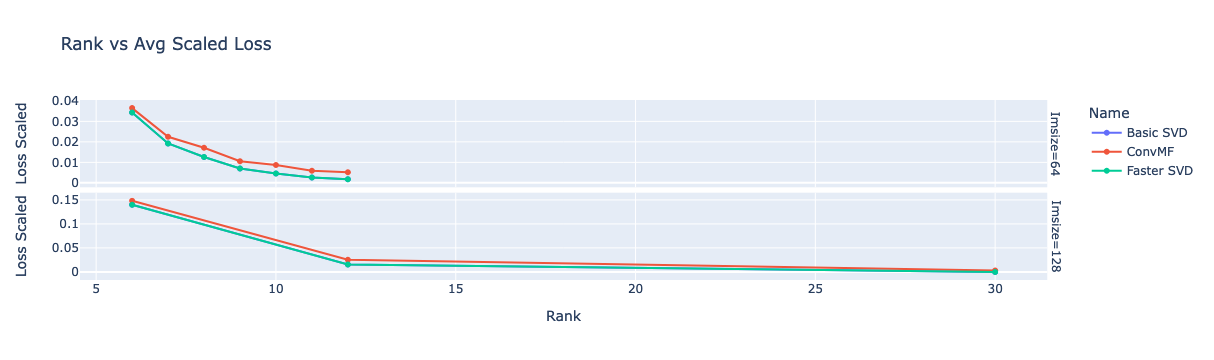

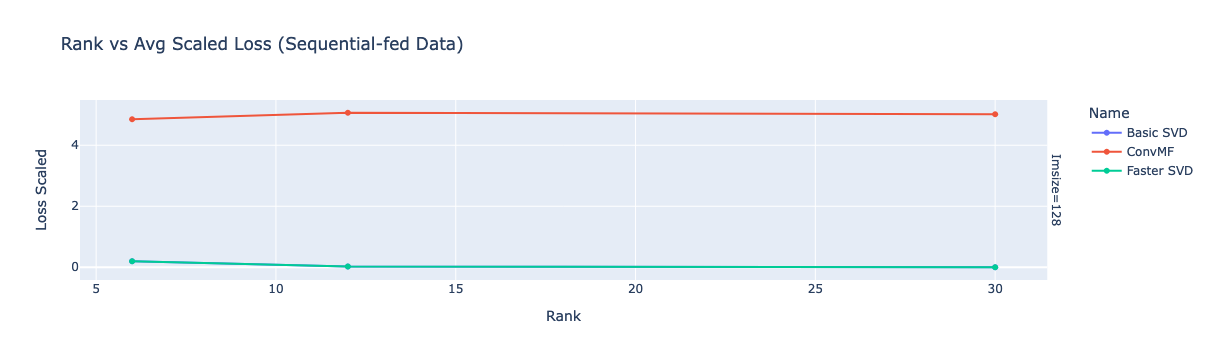

In [29]:
losses_avg = pd.DataFrame(df_losses.groupby(["Imsize", "Name", "Rank"], observed=True)["Loss Scaled"].mean()).reset_index()
fig = px.line(losses_avg, x="Rank", y="Loss Scaled", color="Name", title="Rank vs Avg Scaled Loss", 
              facet_row="Imsize", 
              markers=True,
             )

# Make the 2 plots zooming independent
fig.update_yaxes(matches=None)
fig.update_yaxes(showspikes=True, spikemode='toaxis', spikesnap='cursor')
fig.update_xaxes(showspikes=True, spikemode='toaxis', spikesnap='cursor')
fig.update_layout(height=700)
fig.write_image("images/rank_vs_avg_scaled_loss.pdf")
fig.show()

losses_avg_seq = pd.DataFrame(df_losses_seq.groupby(["Imsize", "Name", "Rank"], observed=True)["Loss Scaled"].mean()).reset_index()
fig = px.line(losses_avg_seq, x="Rank", y="Loss Scaled", color="Name", title="Rank vs Avg Scaled Loss (Sequential-fed Data)", facet_row="Imsize", markers=True)

# Make the 2 plots zooming independent
fig.update_yaxes(matches=None)
fig.update_yaxes(showspikes=True, spikemode='toaxis', spikesnap='cursor')
fig.update_xaxes(showspikes=True, spikemode='toaxis', spikesnap='cursor')
# fig.update_layout(height=700)
fig.write_image("images/rank_vs_avg_scaled_loss_seq.pdf")
fig.show()

## Loss Comparision per matrix

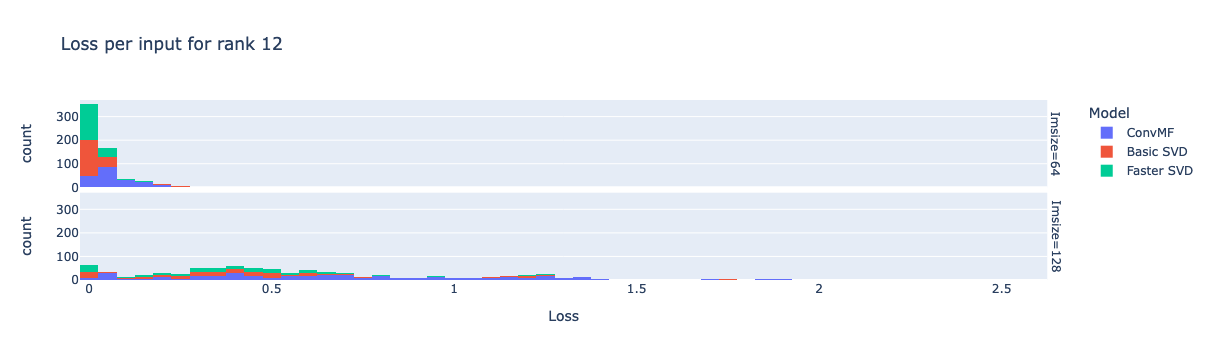

In [41]:
df_r12 = df_losses[df_losses["Rank"] == 12]

fig = px.histogram(df_r12, x="Loss", color="Model", 
                   facet_row="Imsize", 
                   title="Loss per input for rank 12", 
                   marginal="violin")
fig.update_layout(height=600)
fig.show()

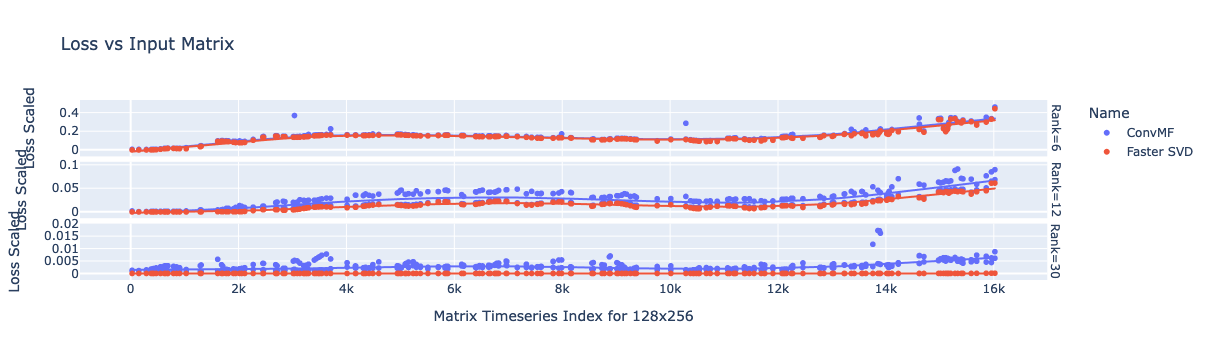

In [35]:
df_n128 = df_losses[(df_losses["Imsize"] == 128) & (df_losses["Name"].isin(["Faster SVD", "ConvMF"]))].sort_values(["Img", "Rank"])

fig = px.scatter(df_n128, x="Img", y="Loss Scaled", color="Name", 
                 title="Scaled Loss vs Input Matrix", facet_row="Rank", 
                 trendline='lowess', 
                 trendline_options=dict(frac=0.3)
                )

fig.update_yaxes(showspikes=True, spikemode='toaxis', spikesnap='cursor', matches=None)
fig.update_xaxes(showspikes=True, spikemode='toaxis', spikesnap='cursor')
# fig.update_traces(mode = 'lines')
fig.update_layout(height=800, xaxis_title="Matrix Timeseries Index for 128x256")
fig.show()


## Execution Time Comparison

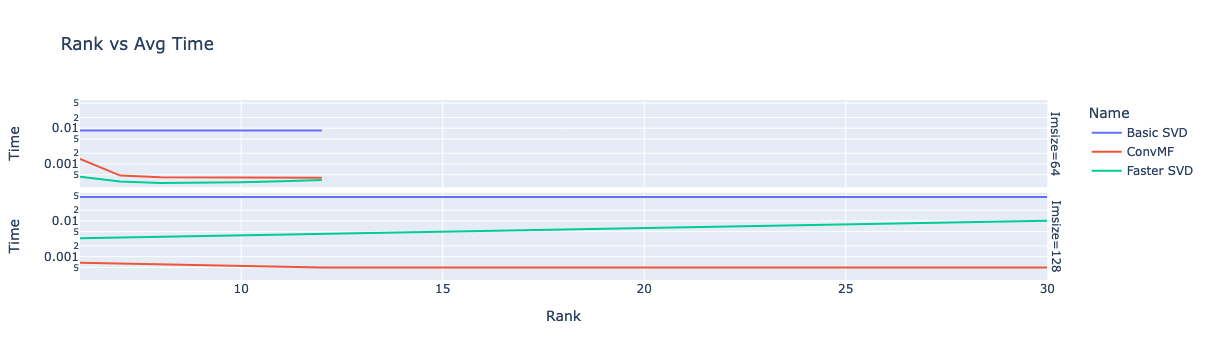

In [34]:
times_avg = pd.DataFrame(df_losses.groupby(["Imsize", "Rank", "Name"], observed=True)["Time"].mean()).reset_index()
fig = px.line(times_avg, x="Rank", y="Time", color="Name", title="Rank vs Avg Time", facet_row="Imsize", log_y=True)
fig.update_layout(height=700)
fig.show()

## Generate figures for paper

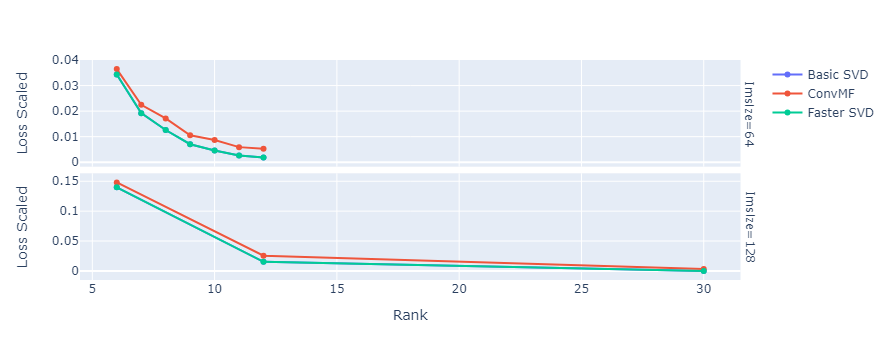

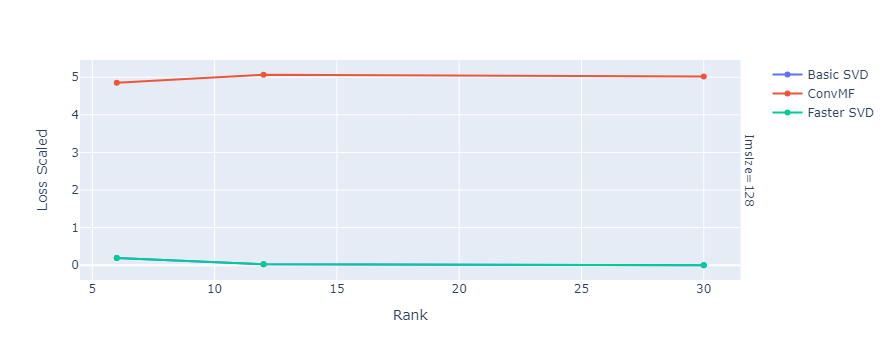

In [30]:
losses_avg = pd.DataFrame(df_losses.groupby(["Imsize", "Name", "Rank"], observed=True)["Loss Scaled"].mean()).reset_index()
fig = px.line(losses_avg, x="Rank", y="Loss Scaled", color="Name", 
              # title="Rank vs Avg Scaled Loss",
              facet_row="Imsize", 
              markers=True,
             )

# Make the 2 plots zooming independent
fig.update_yaxes(matches=None)
fig.update_layout(legend_title_text='')
fig.update_yaxes(showspikes=True, spikemode='toaxis', spikesnap='cursor')
fig.update_xaxes(showspikes=True, spikemode='toaxis', spikesnap='cursor')
fig.update_layout(height=700)
fig.write_image("images/rank_vs_avg_scaled_loss.pdf")
fig.show()

losses_avg_seq = pd.DataFrame(df_losses_seq.groupby(["Imsize", "Name", "Rank"], observed=True)["Loss Scaled"].mean()).reset_index()
fig = px.line(losses_avg_seq, x="Rank", y="Loss Scaled", color="Name", 
              # title="Rank vs Avg Scaled Loss (Sequential-fed Data)", 
              facet_row="Imsize", markers=True)

# Make the 2 plots zooming independent
fig.update_yaxes(matches=None)
fig.update_layout(legend_title_text='')
fig.update_yaxes(showspikes=True, spikemode='toaxis', spikesnap='cursor')
fig.update_xaxes(showspikes=True, spikemode='toaxis', spikesnap='cursor')
# fig.update_layout(height=700)
fig.write_image("images/rank_vs_avg_scaled_loss_seq.pdf")
fig.show()



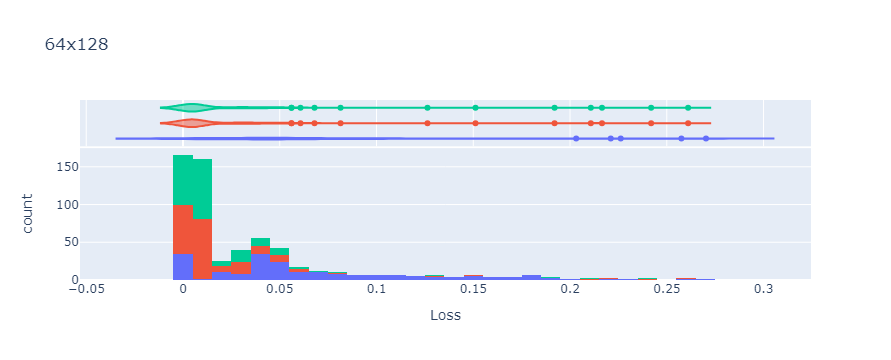

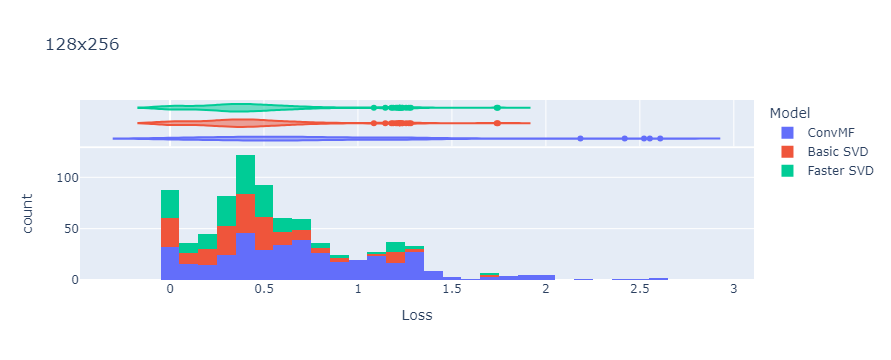

In [50]:
df_r12 = df_losses[df_losses["Rank"] == 12]

fig = px.histogram(df_r12[df_r12["Imsize"] == 64], x="Loss", color="Model", 
                   # facet_row="Imsize", 
                   # title="Loss per input for rank 12", 
                   title="64x128", 
                   marginal="violin")
fig.update_layout(height=600, legend_visible=False)
fig.write_image("images/loss_hist_r12_i64.pdf")
fig.show()

fig = px.histogram(df_r12[df_r12["Imsize"] == 128], x="Loss", color="Model", 
                   # facet_row="Imsize", 
                   title="128x256", 
                   # title="Loss per input for rank 12", 
                   marginal="violin")
fig.update_layout(height=600)
fig.write_image("images/loss_hist_r12_i128.pdf")
fig.show()

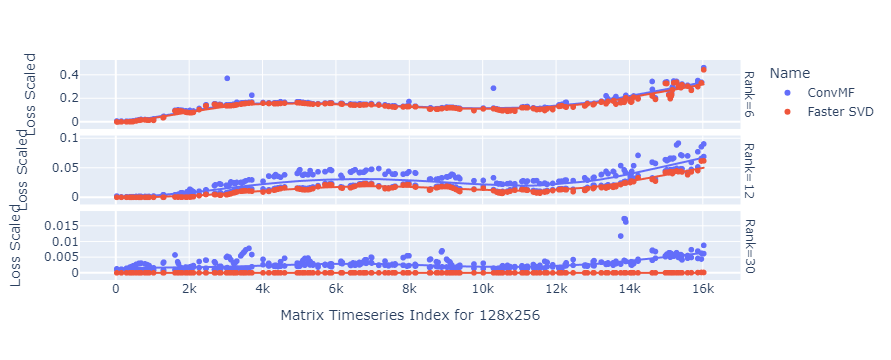

In [52]:
df_n128 = df_losses[(df_losses["Imsize"] == 128) & (df_losses["Name"].isin(["Faster SVD", "ConvMF"]))].sort_values(["Img", "Rank"])

fig = px.scatter(df_n128, x="Img", y="Loss Scaled", color="Name", 
                 # title="Scaled Loss vs Input Matrix", 
                 facet_row="Rank", 
                 trendline='lowess', 
                 trendline_options=dict(frac=0.3)
                )

fig.update_yaxes(showspikes=True, spikemode='toaxis', spikesnap='cursor', matches=None)
fig.update_xaxes(showspikes=True, spikemode='toaxis', spikesnap='cursor')
# fig.update_traces(mode = 'lines')
fig.update_layout(height=800, xaxis_title="Matrix Timeseries Index for 128x256")
fig.write_image("images/loss_byinput.pdf")
fig.show()

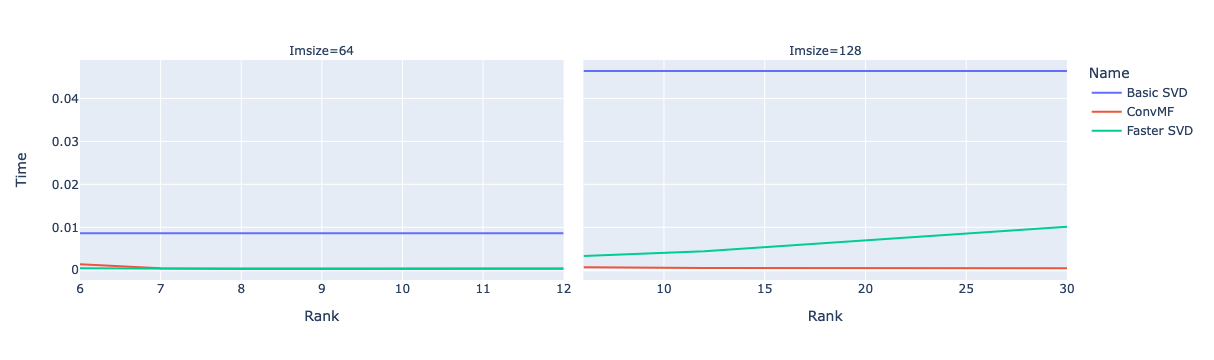

In [47]:
times_avg = pd.DataFrame(df_losses.groupby(["Imsize", "Rank", "Name"], observed=True)["Time"].mean()).reset_index()
fig = px.line(times_avg, x="Rank", y="Time", color="Name", 
              # title="Rank vs Avg Time", 
              facet_col="Imsize", 
              # log_y=True
             )
fig.update_xaxes(matches=None)
# fig.update_xaxes(matches=None)
fig.update_layout(width=900)
fig.write_image("images/execution_time_rank.pdf")
fig.show()

### Training loss curves

In [49]:
json_path = os.path.normpath("../../data/tb_data/")
paths = ["newloss_n128_training", "newloss_n128_validation", "data_seq_Training", "data_seq_Validation", "data_gen_seq_Training", "data_gen_seq_Validation"]
paths = [os.path.join(json_path, f"PC_ConvMF_img128_cdim2-c00f_plasma_{x}.json") for x in paths]

dfs = [pd.read_json(p) for p in paths]

dfs[5]

0       1           2
0    1.726164e+09    1199  155.391464
1    1.726164e+09    1399  156.228241
2    1.726164e+09    2199  161.204712
3    1.726164e+09    2399  161.494125
4    1.726164e+09    2799  159.504547
..            ...     ...         ...
995  1.726188e+09  412392  149.618256
996  1.726188e+09  412792  148.424561
997  1.726188e+09  412992  148.927856
998  1.726188e+09  413392  148.252396
999  1.726188e+09  413592  149.076843

[1000 rows x 3 columns]

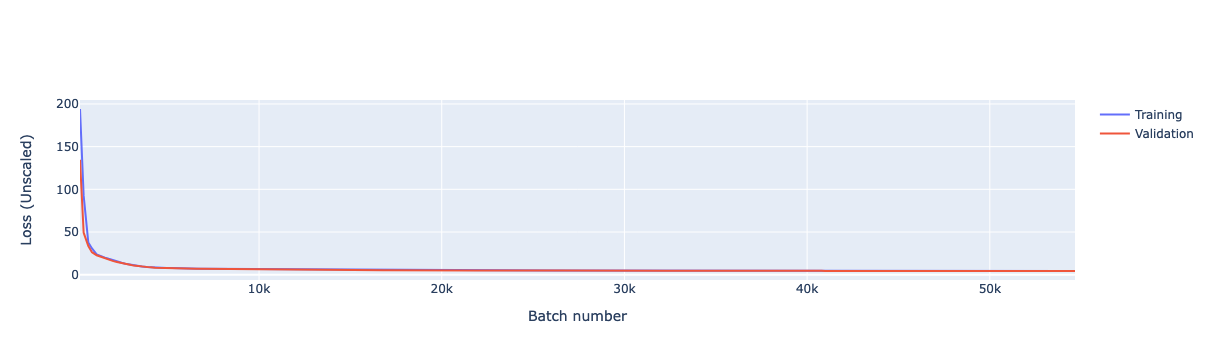

In [26]:
fig = go.Figure(data=go.Scatter(x=dfs[0][1], y=dfs[0][2], mode="lines", name="Training"))
fig.add_trace(go.Scatter(x=dfs[1][1], y=dfs[1][2], mode="lines", name="Validation"))
fig.update_layout(xaxis_title="Batch number", yaxis_title="Loss (Unscaled)")
fig.write_image("images/trainingloss_main.pdf")
fig.show()

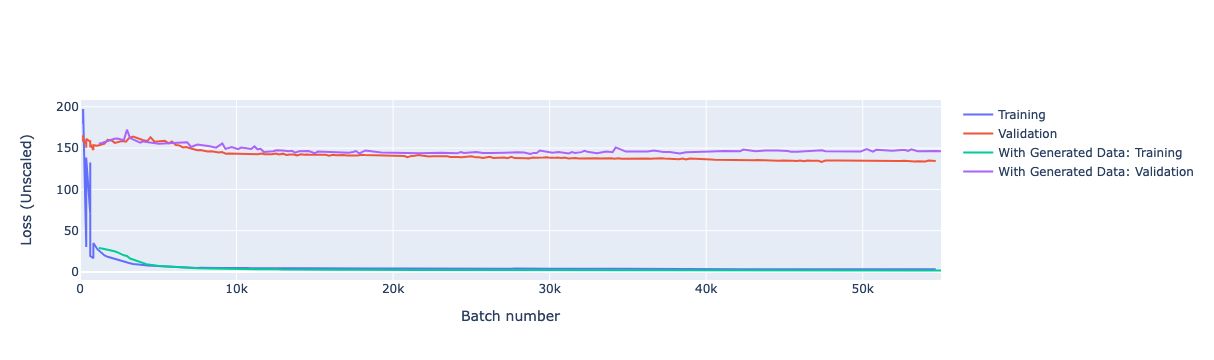

In [53]:
dfs[2] = dfs[2].sort_values(1)
dfs[3] = dfs[3].sort_values(1)

fig = go.Figure(data=go.Scatter(x=dfs[2][1], y=dfs[2][2], mode="lines", name="Training"))
fig.add_trace(go.Scatter(x=dfs[3][1], y=dfs[3][2], mode="lines", name="Validation"))
fig.add_trace(go.Scatter(x=dfs[4][1], y=dfs[4][2], mode="lines", name="With Generated Data: Training"))
fig.add_trace(go.Scatter(x=dfs[5][1], y=dfs[5][2], mode="lines", name="With Generated Data: Validation"))
fig.update_xaxes(range=[0, 55000])
fig.update_layout(xaxis_title="Batch number", yaxis_title="Loss (Unscaled)")
fig.write_image("images/trainingloss_seq_data.pdf")
fig.show()

## Further Work

* Train and compare on 4D simulated plasma data
* Try transfer learning from smaller datasets, to larger
* Use output of the NN at time `t-1` to prime the python SVD at time `t`, to test speed increase
* Creation of corpus of training data, with as much/variety of initial conditions as possible
* Priming of SVD
    * Classical priming
    * Include rank 3r truncation timing 

## Further Research Questions

* How large rank can one go when aiming for "low" rank?